<a href="https://colab.research.google.com/github/soyoonjeong/PyTorch_Tutorial/blob/main/Dataset_%26_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적
- torch.utils.data.DataLoader와 torch.utils.data.Dataset을 통해 미리 준비해둔 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 함
- Dataset은 샘플과 정답(label)을 저장하고 DataLoader은 Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체로 감쌉니다.

## 데이터셋 불러오기

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = 'data', # root : 학습/테스트 데이터가 저장되는 경로
    train = True, # 학습용 또는 테스트용 데이터셋 여부를 지정
    download = True, # download = True는 root에 데이터가 없는 경우 인터넷에서 다운로드함
    transform = ToTensor() # transform와 target_transform : 특징과 정답 변형 지정
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11824701.38it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202552.93it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3803423.91it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3464742.78it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## 데이터셋을 순회하고 시각화하기

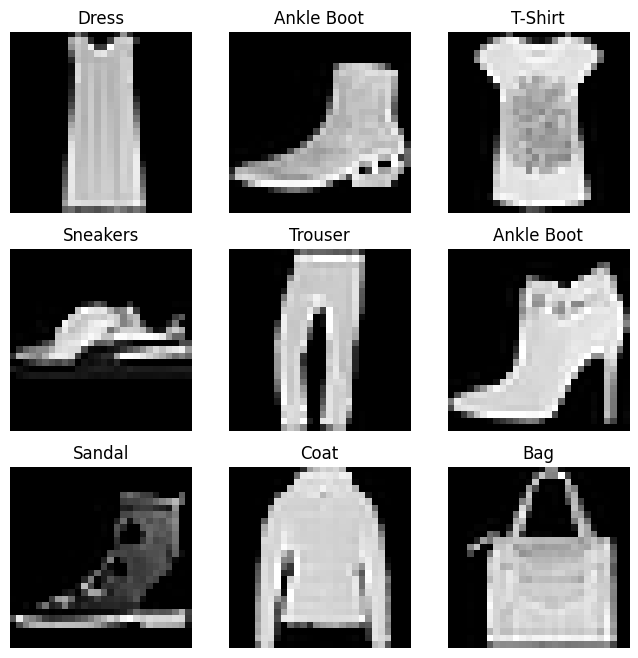

In [5]:
labels_map = {
    0 : "T-Shirt",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneakers",
    8 : "Bag",
    9 : "Ankle Boot",
}
figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size = (1,)).item() # torch.randint : 랜덤 텐서 출력
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 \_\_init__, \_\_len__, \_\_getitem__ 세 개의 함수를 구현해야 함

- \_\_init__ 함수 : Dataset 객체가 생성될 때 한 번만 실행됨, 이미지와 주석 파일이 포함된 디렉토리와 두 가지 변형을 초기화함
- \_\_len__ 함수 : 데이터셋의 샘플 개수 반환
- \_\_getitem__ 함수 : 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환함

In [7]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
    self.img_labels = pd.read_csv(annotations_file, names = ['file_names', 'label']) # 정답은 annotation_file csv 파일에 별도로 저장됨
    self.img_dir = img_dir # FashionMNIST 이미지들은 img_dir 디렉토리에 저장됨
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path) # 이미지를 텐서로 변환
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label


## DataLoader로 학습용 데이터 준비하기

- Dataset은 데이터셋의 특징을 가져오고 하나의 샘플에 정답을 지정하는 일을 한 번에 함, 모델을 학습할 때는 일반적으로 샘플들을 미니배치로 전달하고 매 에폭마다 데이터를 다시 섞어서 과적합을 막습니다.
- DataLoader는 간단한 API로 위의 복잡한 과정들을 추상화한 순회 가능한 객체


In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

## DataLoader를 통해 순회하기

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape : torch.Size([64])


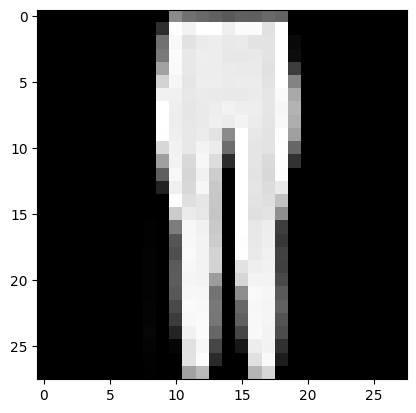

Label : 1


In [9]:
train_features, train_labels = next(iter(train_dataloader)) # 미니배치 하나씩
print(f"Feature batch shape : {train_features.size()}")
print(f"Labels batch shape : {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = 'gray')
plt.show()
print(f"Label : {label}")